In [1]:
import seaborn as sns
from alphaanalysis.plot.gam import get_sig_intervals
from matplotlib import pyplot as plt

# Data Base

In [ ]:
from IPython.display import clear_output

from djimaging.user.alpha.schemas.alpha_schema import *
from djimaging.user.alpha.utils import database

indicator = 'glutamate'
database.connect_dj(indicator=indicator)
clear_output()

# Data

In [ ]:
rf_tab = database.get_rf_tab(quality_filter=True).proj(rf_size='rf_cdia_um', surround_index='full_surround_index') * FieldPosMetrics.RoiPosMetrics.proj(soma_dist='d_dist_to_soma') * RetinalFieldLocationCat().proj(group="nt_side")
df = rf_tab.fetch(format='frame').reset_index()

In [4]:
import utils

df = utils.prep_df(df)
df.head()

,experimenter,date,exp_num,field,cond1,roi_id,rf_size,surround_index,soma_dist,group,cell_id,field_id
0,Ran,2020-11-03,1,d1,control,1,85.3178,-0.021812,95.1105,t,2020-11-03_1,2020-11-03_1_d1
1,Ran,2020-11-03,1,d1,control,2,84.0631,-0.021892,98.8116,t,2020-11-03_1,2020-11-03_1_d1
2,Ran,2020-11-03,1,d1,control,3,71.5601,-0.008966,112.2100,t,2020-11-03_1,2020-11-03_1_d1
3,Ran,2020-11-03,1,d1,control,4,82.4659,-0.027127,114.9270,t,2020-11-03_1,2020-11-03_1_d1
4,Ran,2020-11-03,1,d1,control,5,76.6852,-0.036656,132.2170,t,2020-11-03_1,2020-11-03_1_d1


# Plot

In [5]:
from alphaanalysis import plot as plota
plota.set_rc_params()

In [6]:
order = plota.get_order(indicator=indicator)
palette = plota.get_palette(indicator=indicator)
colors = [palette[group] for group in order]

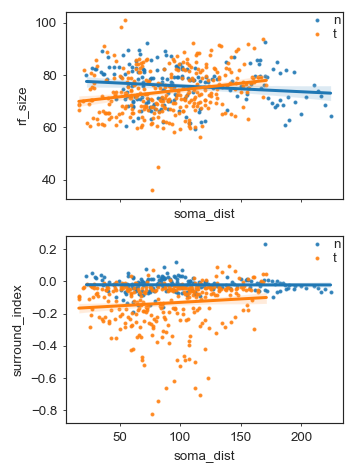

In [7]:
utils.plot_scatter_metrics(df, ['rf_size', 'surround_index'], groupby='group')

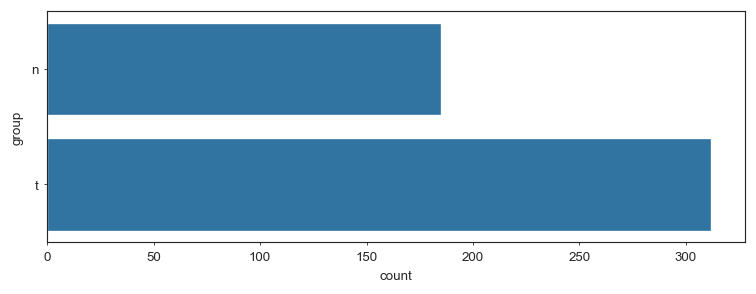

In [8]:
sns.countplot(data=df, y="group");

# Fit GAM

In [9]:
%load_ext rpy2.ipython

In [10]:
%%R
#noqa

rm(list=ls()) 

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


## R imports

In [11]:
%%R
#noqa

library("IRdisplay")
library("dplyr")
library('parallel')
library('ggplot2')
library("nlme")
library("mgcv")
library("ggthemes")
library("itsadug")
library("png")
library("xtable")
library("tidymv")
library("cowplot")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.
Loading required package: plotfunctions

Attaching package: ‘plotfunctions’

The following object is masked from ‘package:ggplot2’:

    alpha

Loaded package itsadug 2.4 (see 'help("itsadug")' ).

Attaching package: ‘xtable’

The following object is masked from ‘package:IRdisplay’:

    display

tidymv has been superseded by tidygam. The package tidymv is no longer maintained but will be
    kept on CRAN to ensure reproducibility of older analyses. Users should
    use the replacement package tidygam for new analyses, which is available on
    CRAN and GitHub (https://github.com/stefanocoretta/tidygam).

Attaching package: ‘tidymv’

Th

# Import R df

In [12]:
%%R -i df -o min_rf_size
#noqa

df$group <- factor(df$group)
df$cell_id <- factor(df$cell_id)
df$field_id <- factor(df$field_id)

min_rf_size <- 0

df <- df[df$soma_dist <= 200, ]
df <- df[df$rf_size >= min_rf_size, ]

head(df)

  experimenter   date exp_num field   cond1 roi_id rf_size surround_index
0          Ran 737732       1    d1 control      1 85.3178    -0.02181220
1          Ran 737732       1    d1 control      2 84.0631    -0.02189200
2          Ran 737732       1    d1 control      3 71.5601    -0.00896591
3          Ran 737732       1    d1 control      4 82.4659    -0.02712750
4          Ran 737732       1    d1 control      5 76.6852    -0.03665570
5          Ran 737732       1    d1 control      6 81.9225    -0.08097780
  soma_dist group      cell_id        field_id
0   95.1105     t 2020-11-03_1 2020-11-03_1_d1
1   98.8116     t 2020-11-03_1 2020-11-03_1_d1
2  112.2100     t 2020-11-03_1 2020-11-03_1_d1
3  114.9270     t 2020-11-03_1 2020-11-03_1_d1
4  132.2170     t 2020-11-03_1 2020-11-03_1_d1
5  104.1770     t 2020-11-03_1 2020-11-03_1_d1


## Helper functions

In [13]:
%%R
#noqa

display_model <- function(m){
    print(summary(m));
    tabs <- capture.output(gamtabs(m, type="HTML"));
    display_html(tabs);
}

## Plot raw data

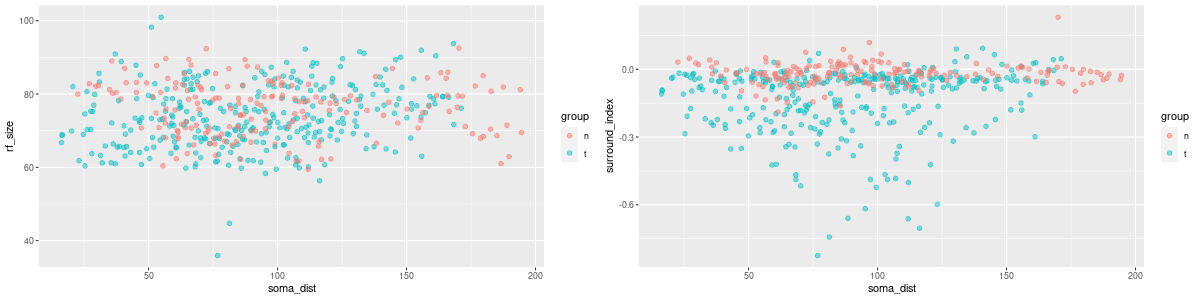

In [14]:
%%R -w 1200 -h 300
#noqa

p1 <- ggplot(aes(x=soma_dist, y=rf_size, color=group), data=df)  +
    geom_point(alpha=.5, size=2)
    
p2 <- ggplot(aes(x=soma_dist, y=surround_index, color=group), data=df)  +
    geom_point(alpha=.5, size=2)
    
plot(plot_grid(p1, p2, ncol=2))

# GAMs

## RF size

In [15]:
%%R
#noqa

m1_size  <- gam(rf_size ~ group + s(soma_dist, k=8, bs="cr"), data=df)
m2_size  <- gam(rf_size ~ group + s(soma_dist, by=group, k=8, bs="cr"), data=df)
m3a_size <- gam(rf_size ~ group + s(soma_dist, by=group, k=8, bs="cr") + s(cell_id, bs="re"), data=df)
m3b_size <- gam(rf_size ~ group + s(soma_dist, by=group, k=8, bs="cr") + s(cell_id, bs="re"), data=df, family='scat')
m4a_size <- gam(rf_size ~ group + s(soma_dist, by=group, k=12, bs="cr") + s(cell_id, bs="re"), data=df)
m4b_size <- gam(rf_size ~ group + s(soma_dist, by=group, k=12, bs="cr") + s(cell_id, bs="re"), data=df, family='scat')
m5a_size <- gam(rf_size ~ group + s(soma_dist, by=group, k=16, bs="cr") + s(cell_id, bs="re"), data=df)
m5b_size <- gam(rf_size ~ group + s(soma_dist, by=group, k=16, bs="cr") + s(cell_id, bs="re"), data=df, family='scat')

In [16]:
%%R
#noqa
BIC(m1_size, m2_size, m3a_size, m3b_size, m4a_size, m4b_size, m5a_size, m5b_size)

                df      BIC
m1_size   9.668893 3475.577
m2_size  14.888232 3489.452
m3a_size 23.817905 3419.856
m3b_size 22.185525 3418.457
m4a_size 24.961313 3426.131
m4b_size 22.520085 3420.411
m5a_size 24.874196 3426.586
m5b_size 22.603741 3421.022


In [17]:
%%R
#noqa
anova(m1_size, m2_size, m3a_size, m4a_size, m5a_size, test="F")

Analysis of Deviance Table

Model 1: rf_size ~ group + s(soma_dist, k = 8, bs = "cr")
Model 2: rf_size ~ group + s(soma_dist, by = group, k = 8, bs = "cr")
Model 3: rf_size ~ group + s(soma_dist, by = group, k = 8, bs = "cr") + 
    s(cell_id, bs = "re")
Model 4: rf_size ~ group + s(soma_dist, by = group, k = 12, bs = "cr") + 
    s(cell_id, bs = "re")
Model 5: rf_size ~ group + s(soma_dist, by = group, k = 16, bs = "cr") + 
    s(cell_id, bs = "re")
  Resid. Df Resid. Dev      Df Deviance       F    Pr(>F)    
1    481.05      30556                                       
2    475.00      29426 6.05416   1129.5  3.8119 0.0009759 ***
3    465.45      22805 9.55022   6621.5 14.1662 < 2.2e-16 ***
4    463.21      22767 2.23632     37.6  0.3433 0.7334867    
5    462.80      22814 0.40809    -46.2                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [18]:
%%R
#noqa
anova(m3b_size, m4b_size, m5b_size, test="F")

Analysis of Deviance Table

Model 1: rf_size ~ group + s(soma_dist, by = group, k = 8, bs = "cr") + 
    s(cell_id, bs = "re")
Model 2: rf_size ~ group + s(soma_dist, by = group, k = 12, bs = "cr") + 
    s(cell_id, bs = "re")
Model 3: rf_size ~ group + s(soma_dist, by = group, k = 16, bs = "cr") + 
    s(cell_id, bs = "re")
  Resid. Df Resid. Dev      Df Deviance Pr(>Chi)
1    467.65     3281.0                          
2    467.14     3280.9 0.51553  0.11819   0.4733
3    466.99     3281.0 0.14257 -0.09283         



Family: Scaled t(12.088,6.444) 
Link function: identity 

Formula:
rf_size ~ group + s(soma_dist, by = group, k = 8, bs = "cr") + 
    s(cell_id, bs = "re")

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   76.214      2.005  38.012   <2e-16 ***
groupt        -3.127      2.612  -1.197    0.231    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                      edf Ref.df Chi.sq p-value    
s(soma_dist):groupn 3.779  4.569  14.20 0.01321 *  
s(soma_dist):groupt 2.975  3.682  15.84 0.00437 ** 
s(cell_id)          9.268 10.000 133.13 < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.268   Deviance explained = 27.9%
-REML = 1663.4  Scale est. = 1         n = 490

Method: REML   Optimizer: outer newton
full convergence after 4 iterations.
Gradient range [-0.0001234492,8.865091e-05]
(score 1663.37 & scale 1).
Hessian positive definite, 

In addition: Warning message:
In getOption("jupyter.base_display_func")(data, metadata) :
  IRdisplay can only be used from the IPython R kernel and R magic.


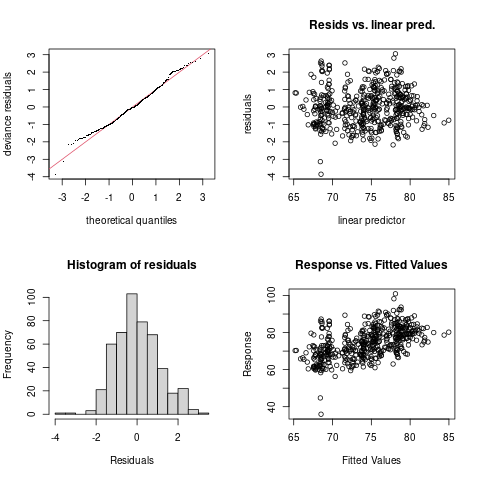

In [19]:
%%R
#noqa
m_rf_size <- m3b_size
display_model(m_rf_size)
gam.check(m_rf_size)

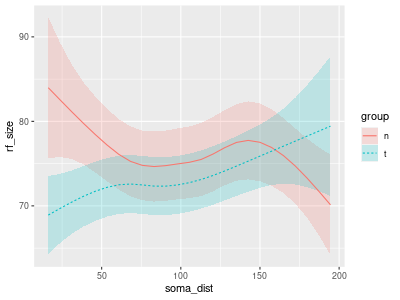

In [20]:
%%R -w 400 -h 300
#noqa

p1 <- plot_smooths(model=m_rf_size, series=soma_dist, comparison=group)
plot(p1, ylim=c(0, 60))

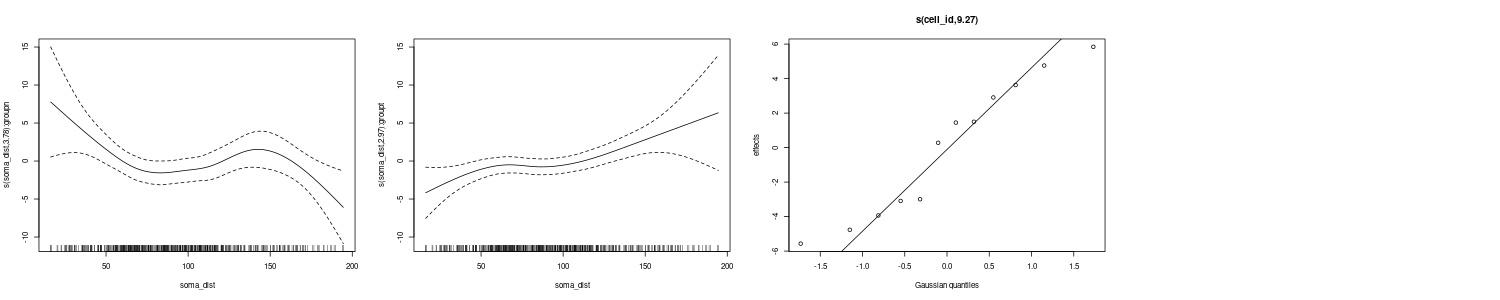

In [21]:
%%R -w 1500 -h 300
#noqa

par(mfrow = c(1,4))
plot(m_rf_size)

### Plot fits

In [22]:
%%R
#noqa

r_df_pred_size = predict_gam(m_rf_size, exclude_terms=s(cell_id, bs="re"))
head(r_df_pred_size)

# A tibble: 6 × 5
  group soma_dist cell_id        fit se.fit
  <fct>     <dbl> <fct>        <dbl>  <dbl>
1 n          16.3 2020-11-03_1  84.0   4.25
2 t          16.3 2020-11-03_1  68.9   2.36
3 n          19.9 2020-11-03_1  83.3   3.84
4 t          19.9 2020-11-03_1  69.3   2.21
5 n          23.5 2020-11-03_1  82.6   3.47
6 t          23.5 2020-11-03_1  69.7   2.09


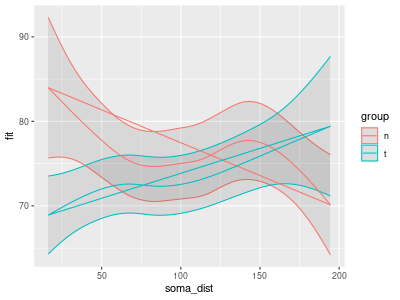

In [23]:
%%R -w 400 -h 300
#noqa

predict_gam(m_rf_size, exclude_terms=s(cell_id, bs="re")) %>%
    ggplot(aes(soma_dist, fit, col=group)) +
    geom_smooth_ci()

### Plot differences 

[1] 1.959964
Summary:
	* soma_dist : numeric predictor; with 100 values ranging from 16.268800 to 194.552000. 
	* cell_id : factor; set to the value(s): 2020-11-03_1. (Might be canceled as random effect, check below.) 
	* NOTE : The following random effects columns are canceled: s(cell_id)
 

soma_dist window(s) of significant difference(s):
	16.268800 - 50.484768


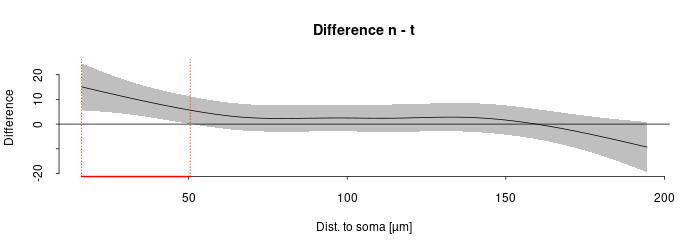

In [24]:
%%R -w 700 -h 250 -o nt_diff_size
#noqa

n_diffs <- 1
par(mfrow=c(1, n_diffs), cex=1.0, tcl=-0.2)

se <- qnorm((100 - (2.5/n_diffs))/100)
print(se)
ylim <- NULL#c(-150, 150)
ylab <- 'Difference'
xlab <- 'Dist. to soma [µm]'

nt_diff_size <- plot_diff(m_rf_size, view="soma_dist", comp=list(group=c("n", "t")), se=se, ylab=ylab, xlab=xlab, ylim=ylim, hide.label=TRUE)

In [25]:
pairs_sig_regions_size = [
    ("n vs. t", get_sig_intervals(nt_diff_size)),
]
pairs_sig_regions_size

[ 0 19]
[]


[('n vs. t', [(16.2688, 50.484767676767675)])]

## Surround index

In [26]:
%%R
#noqa

m1_surr <- gam(surround_index ~ group + s(soma_dist, k=8, bs="cr"), data=df)
m2_surr <- gam(surround_index ~ group + s(soma_dist, by=group, k=8, bs="cr"), data=df)
m3a_surr <- gam(surround_index ~ group + s(soma_dist, by=group, k=8, bs="cr")+ s(cell_id, bs="re"), data=df)
m3b_surr <- gam(surround_index ~ group + s(soma_dist, by=group, k=8, bs="cr")+ s(cell_id, bs="re"), data=df, family='scat')
m4a_surr <- gam(surround_index ~ group + s(soma_dist, by=group, k=12, bs="cr")+ s(cell_id, bs="re"), data=df)
m4b_surr <- gam(surround_index ~ group + s(soma_dist, by=group, k=12, bs="cr")+ s(cell_id, bs="re"), data=df, family='scat')
m5a_surr <- gam(surround_index ~ group + s(soma_dist, by=group, k=16, bs="cr")+ s(cell_id, bs="re"), data=df)
m5b_surr <- gam(surround_index ~ group + s(soma_dist, by=group, k=16, bs="cr")+ s(cell_id, bs="re"), data=df, family='scat')

In [27]:
%%R
#noqa
BIC(m1_surr, m2_surr, m3a_surr, m3b_surr, m4a_surr, m4b_surr, m5a_surr, m5b_surr)

                df        BIC
m1_surr   6.936863  -653.6735
m2_surr   6.663184  -663.7879
m3a_surr 19.855244  -975.7895
m3b_surr 20.473580 -1267.0771
m4a_surr 16.689842  -989.8196
m4b_surr 20.774972 -1264.2967
m5a_surr 16.708394  -989.7321
m5b_surr 20.904650 -1263.3876


In [28]:
%%R
#noqa
anova(m1_surr, m2_surr, m3a_surr, m4a_surr, m5a_surr, test="F")

Analysis of Deviance Table

Model 1: surround_index ~ group + s(soma_dist, k = 8, bs = "cr")
Model 2: surround_index ~ group + s(soma_dist, by = group, k = 8, bs = "cr")
Model 3: surround_index ~ group + s(soma_dist, by = group, k = 8, bs = "cr") + 
    s(cell_id, bs = "re")
Model 4: surround_index ~ group + s(soma_dist, by = group, k = 12, bs = "cr") + 
    s(cell_id, bs = "re")
Model 5: surround_index ~ group + s(soma_dist, by = group, k = 16, bs = "cr") + 
    s(cell_id, bs = "re")
  Resid. Df Resid. Dev        Df Deviance       F  Pr(>F)    
1    483.25     6.9227                                       
2    483.70     6.8048 -0.449687   0.1179                    
3    469.48     3.0469 14.212873   3.7579 40.8849 < 2e-16 ***
4    473.44     3.0818 -3.954811  -0.0349  1.3638 0.24585    
5    473.40     3.0816  0.034947   0.0002  0.7627 0.06376 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [29]:
%%R
#noqa
anova(m3b_surr, m4b_surr, m5b_surr, test="F")

Analysis of Deviance Table

Model 1: surround_index ~ group + s(soma_dist, by = group, k = 8, bs = "cr") + 
    s(cell_id, bs = "re")
Model 2: surround_index ~ group + s(soma_dist, by = group, k = 12, bs = "cr") + 
    s(cell_id, bs = "re")
Model 3: surround_index ~ group + s(soma_dist, by = group, k = 16, bs = "cr") + 
    s(cell_id, bs = "re")
  Resid. Df Resid. Dev      Df Deviance Pr(>Chi)
1    470.63    -1393.9                          
2    470.10    -1393.0 0.53269 -0.91343         
3    469.89    -1392.9 0.20951 -0.10582         



Family: Scaled t(3,0.038) 
Link function: identity 

Formula:
surround_index ~ group + s(soma_dist, by = group, k = 8, bs = "cr") + 
    s(cell_id, bs = "re")

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)  
(Intercept) -0.02034    0.03968  -0.512   0.6083  
groupt      -0.10261    0.05192  -1.976   0.0481 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                      edf Ref.df   Chi.sq p-value    
s(soma_dist):groupn 4.660  5.474   10.209  0.0712 .  
s(soma_dist):groupt 1.000  1.000    0.044  0.8344    
s(cell_id)          9.919 10.000 1269.273  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.608   Deviance explained = 48.1%
-REML = -643.3  Scale est. = 1         n = 490

Method: REML   Optimizer: outer newton
full convergence after 12 iterations.
Gradient range [-0.000710812,0.0001755285]
(score -643.3046 & scale 1).
Hessian positive defi

In addition: Warning message:
In getOption("jupyter.base_display_func")(data, metadata) :
  IRdisplay can only be used from the IPython R kernel and R magic.


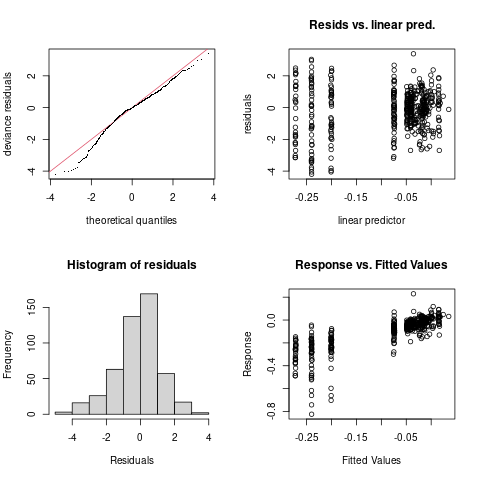

In [30]:
%%R
#noqa
m_surround <- m3b_surr
display_model(m_surround)
gam.check(m_surround)

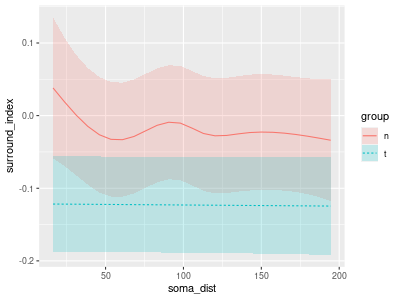

In [31]:
%%R -w 400 -h 300
#noqa

p1 <- plot_smooths(model=m_surround, series=soma_dist, comparison=group)
plot(p1, ylim=c(0, 60))

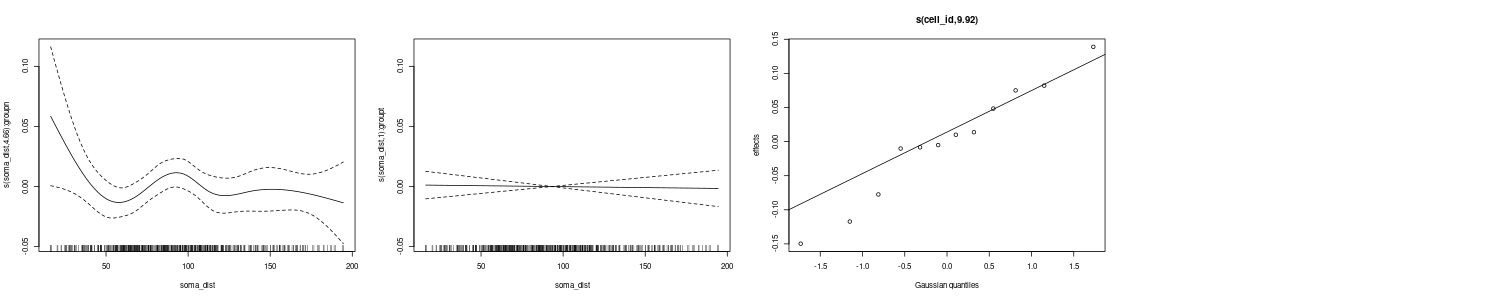

In [32]:
%%R -w 1500 -h 300
#noqa

par(mfrow = c(1,4))
plot(m_surround)

### Plot fits

In [33]:
%%R
#noqa

r_df_pred_surround = predict_gam(m_surround, exclude_terms=s(cell_id, bs="re"))
head(r_df_pred_surround)

# A tibble: 6 × 5
  group soma_dist cell_id          fit se.fit
  <fct>     <dbl> <fct>          <dbl>  <dbl>
1 n          16.3 2020-11-03_1  0.0381 0.0496
2 t          16.3 2020-11-03_1 -0.122  0.0339
3 n          19.9 2020-11-03_1  0.0285 0.0472
4 t          19.9 2020-11-03_1 -0.122  0.0339
5 n          23.5 2020-11-03_1  0.0191 0.0451
6 t          23.5 2020-11-03_1 -0.122  0.0339


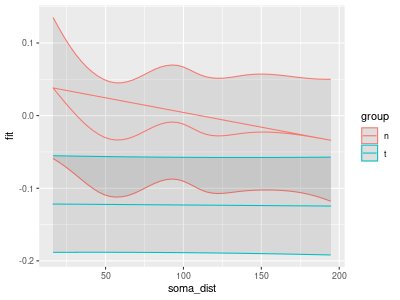

In [34]:
%%R -w 400 -h 300
#noqa

predict_gam(m_surround, exclude_terms=s(cell_id, bs="re")) %>%
    ggplot(aes(soma_dist, fit, col=group)) +
    geom_smooth_ci()

### Plot differences 

[1] 1.959964
Summary:
	* soma_dist : numeric predictor; with 100 values ranging from 16.268800 to 194.552000. 
	* cell_id : factor; set to the value(s): 2020-11-03_1. (Might be canceled as random effect, check below.) 
	* NOTE : The following random effects columns are canceled: s(cell_id)
 

soma_dist window(s) of significant difference(s):
	16.268800 - 39.679725
	77.497374 - 108.111661


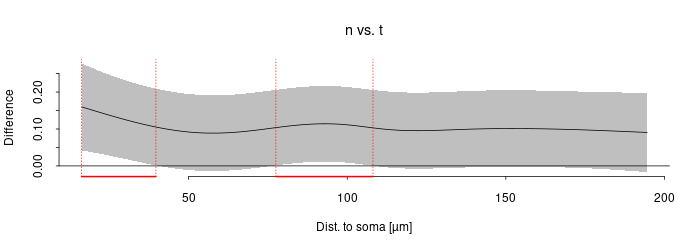

In [35]:
%%R -w 700 -h 250 -o nt_diff_surr
#noqa

n_diffs <- 1
par(mfrow=c(1, n_diffs), cex=1.0, tcl=-0.2)

se <- qnorm((100 - (2.5/n_diffs))/100)
print(se)
ylim <- NULL#c(-150, 150)
view <- "soma_dist"
ylab <- 'Difference'
xlab <- 'Dist. to soma [µm]'

nt_diff_surr <- plot_diff(m_surround, view=view, comp=list(group=c("n", "t")), se=se, main=expression('n vs. t'), ylab=ylab, xlab=xlab, ylim=ylim, hide.label=TRUE)

In [36]:
pairs_sig_regions_surround = [
    ("n vs. t", get_sig_intervals(nt_diff_surr)),
]
pairs_sig_regions_surround

[ 0 13 33 51]
[]


[('n vs. t',
  [(16.2688, 39.67972525252525), (75.69653333333333, 108.11166060606061)])]

# Go back to python for easy plotting

In [37]:
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

with localconverter(ro.default_converter + pandas2ri.converter):
    df_pred_size = ro.conversion.rpy2py(ro.globalenv['r_df_pred_size'])
    df_pred_surround = ro.conversion.rpy2py(ro.globalenv['r_df_pred_surround'])

In [38]:
df_pred_size.head()

,group,soma_dist,cell_id,fit,se.fit
1,n,16.268800,2020-11-03_1,83.984334,4.246829
2,t,16.268800,2020-11-03_1,68.910916,2.356224
3,n,19.907233,2020-11-03_1,83.279844,3.840464
4,t,19.907233,2020-11-03_1,69.297442,2.214327
5,n,23.545665,2020-11-03_1,82.577672,3.467781


In [39]:
df_pred_surround.head()

,group,soma_dist,cell_id,fit,se.fit
1,n,16.268800,2020-11-03_1,0.038107,0.049579
2,t,16.268800,2020-11-03_1,-0.121749,0.033948
3,n,19.907233,2020-11-03_1,0.028545,0.047168
4,t,19.907233,2020-11-03_1,-0.121806,0.033905
5,n,23.545665,2020-11-03_1,0.019136,0.045130


(3, 3)


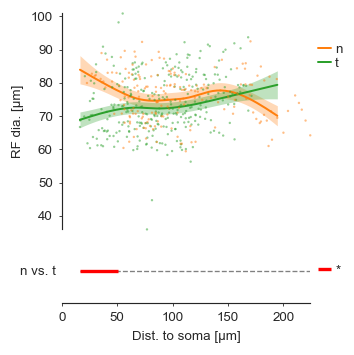

In [40]:
fig, axs = utils.plot_fits(
    df=df,
    df_preds=[df_pred_size],
    pairs_sig_regions_list=[pairs_sig_regions_size],
    titles=[None],
    ys=['rf_size'],
    ylabels=['RF dia. [µm]'],
    x='soma_dist',
    xlabel='Dist. to soma [µm]',
    order=order,
    colors=colors,
    figsize=(3, 3),
)

plt.savefig(f'figures/{indicator}_soma_dist_rf_size.pdf')
plt.show()

(3, 3)


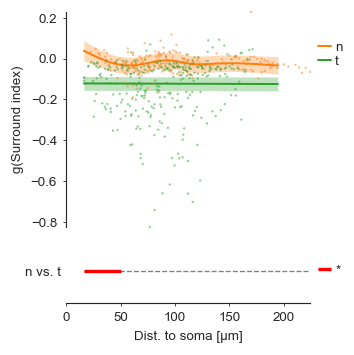

In [41]:
fig, axs = utils.plot_fits(
    df=df,
    df_preds=[df_pred_surround],
    pairs_sig_regions_list=[pairs_sig_regions_size],
    titles=[None],
    ys=['surround_index'],
    ylabels=['g(Surround index)'],
    x='soma_dist',
    xlabel='Dist. to soma [µm]',
    order=order,
    colors=colors,
    figsize=(3, 3),
)

plt.show()

(2, 2)


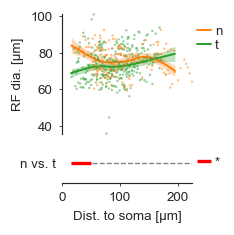

In [42]:
fig, axs = utils.plot_fits(
    df=df,
    df_preds=[df_pred_size],
    pairs_sig_regions_list=[pairs_sig_regions_size],
    titles=[None],
    ys=['rf_size'],
    ylabels=['RF dia. [µm]'],
    x='soma_dist',
    xlabel='Dist. to soma [µm]',
    order=order,
    colors=colors,
    figsize=(2, 2),
)

(1.6, 2.3)


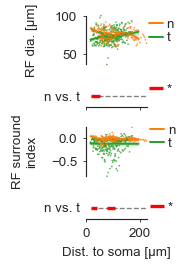

In [43]:
fig, axs = utils.plot_fits(
    df=df,
    df_preds=[df_pred_size, df_pred_surround],
    pairs_sig_regions_list=[pairs_sig_regions_size, pairs_sig_regions_surround],
    titles=[None, None],
    ys=['rf_size', 'surround_index'],
    ylabels=['RF dia. [µm]', 'RF surround\nindex'],
    x='soma_dist',
    xlabel='Dist. to soma [µm]',
    order=order,
    colors=colors,
    figsize=(1.6, 2.3),
    is_row=False,
    ms=1,
    ma=0.8,
)

fig.align_labels()
plt.tight_layout()
plt.savefig(f'figures/{indicator}_soma_dist.pdf')
plt.show()